In [1]:
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns
import spacy
import nltk
import re
import string
from langdetect import detect
from collections import Counter
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words

In [2]:
# file
file_path = '../Combined Data.csv'

In [3]:
# check the data
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
# drop rows with suicidal status
df = df[df['status'] != 'Suicidal']

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42390 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  42390 non-null  int64 
 1   statement   42029 non-null  object
 2   status      42390 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [5]:
# drop rows with null columns
df_cleaned = df.dropna()
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42029 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  42029 non-null  int64 
 1   statement   42029 non-null  object
 2   status      42029 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [6]:
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [7]:
# separate the data into multiple dfs based on their label
df_normal = df_cleaned[df_cleaned['status'] == 'Normal']
df_bipolar = df_cleaned[df_cleaned['status'] == 'Bipolar']
df_stress = df_cleaned[df_cleaned['status'] == 'Stress']
df_depression = df_cleaned[df_cleaned['status'] == 'Depression']
df_anxiety = df_cleaned[df_cleaned['status'] == 'Anxiety']
df_personalitydis= df_cleaned[df_cleaned['status'] == 'Personality disorder']

dataframes = [df_normal, df_bipolar, df_stress, df_depression, df_anxiety, df_personalitydis]

for df in dataframes:
    df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16343 entries, 733 to 45393
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  16343 non-null  int64 
 1   statement   16343 non-null  object
 2   status      16343 non-null  object
dtypes: int64(1), object(2)
memory usage: 510.7+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 2777 entries, 45394 to 50653
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2777 non-null   int64 
 1   statement   2777 non-null   object
 2   status      2777 non-null   object
dtypes: int64(1), object(2)
memory usage: 86.8+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 2587 entries, 27346 to 49468
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2587 non-null   int64 
 1   statement   2587 non-null   object
 2   status      258

In [8]:
# initiate list for training data dfs, validation data dfs, and test data dfs
train_list = []
val_list = []
test_list = []

In [9]:
# split each df in dataframes for training and validation
for df in dataframes:
    # shuffle
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # split
    split_training_index = int(0.75 * len(df))
    split_val_index = int(0.9 * len(df))

    train_df = df[:split_training_index]  # first 75%
    val_df = df[split_training_index:split_val_index] # 15% after
    test_df = df[split_val_index:] # remaining 10%

    # add to list
    train_list.append(train_df)
    val_list.append(val_df)
    test_list.append(test_df)

In [10]:
# concatenate all the dfs in each list
train_set = pd.concat(train_list).reset_index(drop=True)
val_set = pd.concat(val_list).reset_index(drop=True)
test_set = pd.concat(test_list).reset_index(drop=True)

print(len(train_set), len(val_set), len(test_set))

31519 6304 4206


In [11]:
def custom_resampling(df):
    # status on the 3rd quantile
    percentile_class_size = df['status'].value_counts().quantile(0.75)

    # resampling
    balanced_dfs = [
        resample(
        df_cleaned[df_cleaned['status'] == label],
        replace=True if len(df_cleaned[df_cleaned['status'] == label]) < percentile_class_size else False,
        n_samples=int(percentile_class_size),
        random_state=42
        )
        for label in df['status'].unique()
    ]

    return pd.concat(balanced_dfs).sample(frac=1, random_state=42)

In [12]:
train_set = custom_resampling(train_set)
val_set = custom_resampling(val_set)
test_set = custom_resampling(test_set)

In [13]:
print(len(train_set), len(val_set), len(test_set))

56304 11256 7512


In [14]:
# Check the distribution of labels in the 'status' column
label_distribution = train_set['status'].value_counts()

print(label_distribution)

status
Stress                  9384
Normal                  9384
Depression              9384
Anxiety                 9384
Personality disorder    9384
Bipolar                 9384
Name: count, dtype: int64


In [15]:
# Check the distribution of labels in the 'status' column
label_distribution = val_set['status'].value_counts()

print(label_distribution)

status
Bipolar                 1876
Personality disorder    1876
Normal                  1876
Anxiety                 1876
Stress                  1876
Depression              1876
Name: count, dtype: int64


In [16]:
# Check the distribution of labels in the 'status' column
label_distribution = test_set['status'].value_counts()

print(label_distribution)

status
Depression              1252
Anxiety                 1252
Normal                  1252
Stress                  1252
Personality disorder    1252
Bipolar                 1252
Name: count, dtype: int64


In [17]:
train_set['statement'] = train_set['statement'].str.lower()
val_set['statement'] = val_set['statement'].str.lower()
train_set.head(20)

,Unnamed: 0,statement,status
48410,48410,looking for participants to use a mobile app d...,Stress
5761,5761,mejiko,Normal
28487,28487,he goes in the bedroom and we only have one ca...,Stress
24112,24112,it feels like no one will ever choose to spend...,Depression
421,421,mentally down because social media is not that...,Anxiety
10073,10073,sometimes somebody tells me something and i ge...,Depression
30165,30165,"this sucks, we're booking plane tickets next w...",Stress
50969,50969,apathy is a defense mechanism for those who fe...,Personality disorder
52935,52935,scared to start lexapro i have a crippling anx...,Anxiety
35418,35418,shaft ring too tight...worried used a rubber r...,Anxiety


In [18]:
train_set['statement'] = train_set['statement'].str.replace("’", "'")
val_set['statement'] = val_set['statement'].str.replace("’", "'")

In [19]:
abb = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "dont": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "idk": "i do not know",
  "he'd've": "he would have",
  "he'll": "he will",  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "i would",
  "i'd've": "i would have",
  "i'll": "i will",
  "i'll've": "i will have",
  "i'm": "i am",
  "im": "i am",
  "i've": "i have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is", "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have", "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",      "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have", "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have", "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

In [20]:
abb_re = re.compile('(%s)' % '|'.join(abb.keys()))

def expandContractions(text, abb_re=abb_re):
    def replace(match):
        return abb[match.group(0)]
    return abb_re.sub(replace, text)

train_set['statement'] = train_set['statement'].apply(expandContractions)
val_set['statement'] = val_set['statement'].apply(expandContractions)

In [21]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [22]:
nltk.download('punkt')

# tokenize text
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

train_set['statement'] = train_set['statement'].apply(tokenize_text)
val_set['statement'] = val_set['statement'].apply(tokenize_text)
train_set.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Unnamed: 0,statement,status
48410,48410,"[looking, for, participants, to, use, a, mobil...",Stress
5761,5761,[mejiko],Normal
28487,28487,"[he, goes, in, the, bedroom, and, we, only, ha...",Stress
24112,24112,"[it, feels, like, no, one, will, ever, choose,...",Depression
421,421,"[mentally, down, because, social, media, is, n...",Anxiety


In [23]:
import wordninja

# word segmentation
train_set['statement'] = train_set['statement'].apply(lambda tokens: wordninja.split(" ".join(tokens)))
val_set['statement'] = val_set['statement'].apply(lambda tokens: wordninja.split(" ".join(tokens)))

In [24]:
from nltk.corpus import stopwords

# Download the list of English stopwords
nltk.download('stopwords')

# Retrieve the English stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from a list of tokens
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

# Apply the stopword removal function to the 'text' column
train_set['statement'] = train_set['statement'].apply(remove_stopwords)
val_set['statement'] = val_set['statement'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
import string

# Function to remove punctuation and digits
def remove_punctuation(tokens):
    return [word for word in tokens if word not in string.punctuation and not word.isdigit()]

# Apply the function to remove punctuation and digits from the 'text' column
train_set['statement'] = train_set['statement'].apply(remove_punctuation)
val_set['statement'] = val_set['statement'].apply(remove_punctuation)

# Display the first few rows of the 'text' column after removal
print(train_set['statement'].head())


48410    [looking, participants, use, mobile, app, desi...
5761                                              [ji, ko]
28487    [goes, bedroom, one, car, take, work, sitting,...
24112    [feels, like, one, ever, choose, spend, ti, fa...
421      [mentally, social, media, good, worried, anyth...
Name: statement, dtype: object


In [26]:
def remove_special_characters(tokens):
    # Remove special characters from each token using a regular expression
    return [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in tokens]

# Apply the function to remove special characters
train_set['statement'] = train_set['statement'].apply(remove_special_characters)
val_set['statement'] = val_set['statement'].apply(remove_special_characters)

In [27]:
# Function to remove extra whitespaces
def remove_extra_whitespaces(tokens):
    # Strip leading and trailing whitespaces and filter out empty strings
    return [word.strip() for word in tokens if word.strip() != '']

train_set['statement'] = train_set['statement'].apply(remove_extra_whitespaces)
val_set['statement'] = val_set['statement'].apply(remove_extra_whitespaces)

In [28]:
import re

# Function to remove URLs 
def remove_url(tokens):
    cleaned_tokens = [re.sub(r'http\S+', '', token) for token in tokens]
    return cleaned_tokens

# Function to remove email addresses 
def remove_mail(tokens):
    cleaned_tokens = [re.sub(r'\S+@\S+', '', token) for token in tokens]
    return cleaned_tokens

# Function to remove emojis 
def remove_emoji(tokens):
    cleaned_tokens = [re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U0001FB00-\U0001FBFF\U0001FE00-\U0001FE0F\U0001F004]+', '', token) for token in tokens]
    return cleaned_tokens

train_set['statement'] = train_set['statement'].apply(remove_url)
train_set['statement'] = train_set['statement'].apply(remove_mail)
train_set['statement'] = train_set['statement'].apply(remove_emoji)

val_set['statement'] = val_set['statement'].apply(remove_url)
val_set['statement'] = val_set['statement'].apply(remove_mail)
val_set['statement'] = val_set['statement'].apply(remove_emoji)

In [29]:
# Load the spaCy English model
import spacy
nlp = spacy.load('en_core_web_sm')

def lemmatize_tokens(tokens):
    # Join the tokens back into a sentence
    text = ' '.join(tokens)
    # Process the text using spaCy
    doc = nlp(text)
    # Lemmatize each token and return the lemmatized tokens
    lemmatized_tokens = [token.lemma_ for token in doc]
    return lemmatized_tokens

# Apply lemmatization t
train_set['statement'] = train_set['statement'].apply(lemmatize_tokens)
val_set['statement'] = val_set['statement'].apply(lemmatize_tokens)

In [30]:
from nltk.corpus import words
import nltk

# Download the list of English words (if not already downloaded)
nltk.download('words')

# Load the set of English words
english_words = set(words.words())

# List of words to exclude from removal
words_to_exclude =  {
    'fuck','suicidal', 'depressed', 'anxiety', 'selfharm', 'overdose', 'hopeless',
    'cutting', 'lifeless', 'worthless', 'painful', 'enditall', 'sadness',
    'goodbye', 'helpme', 'hurtmyself', 'numb', 'alone', 'darkness', 'dying',
    'unloved', 'lost', 'killmyself', 'hanging', 'drugs', 'triggered',
    'relapse', 'cut', 'sh', 'kms', 'plshelp', 'wanttodie', 'tiredoflife'
}

# Function to remove non-English words from a list of tokens
def remove_non_english(tokens):
    english_tokens = [
        token if (token in english_words or token in words_to_exclude) else ''
        for token in tokens]
    return [token for token in english_tokens if token != '']

# Apply the function to the 'text' column in the DataFrame
train_set['statement'] = train_set['statement'].apply(remove_non_english)
val_set['statement'] = val_set['statement'].apply(remove_non_english)

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
# Combine tokens back into a string to process with the Tokenizer
train_set['statement'] = train_set['statement'].apply(lambda tokens: " ".join(tokens))
val_set['statement'] = val_set['statement'].apply(lambda tokens: " ".join(tokens))

In [32]:
print(train_set['statement'].iloc[0])

look participant use mobile design student hi dear student group design mobile base research help focus priority instead short term distraction motivational way try free never regret need help use evaluate week participation highly survey dal ca read follow recruitment notice study title evaluation persuasive mobile application prompt ti management behaviour student part ti full ti enrol degree program high education institution year old able access device invite evaluate effectiveness persuasive am persuade student organize towards task study space first ask give consent study respond survey question take min consist demographic question question preference organization toward task study space level perceive ability control ti stress level answer survey question provide address see link link able device second use daily add daily task organize base port urgency mark complete engage social community feature four week send notification emphasize benefit adhere organizational act encoura

In [33]:
train_set.head(15)

,Unnamed: 0,statement,status
48410,48410,look participant use mobile design student hi ...,Stress
5761,5761,ko,Normal
28487,28487,go bedroom one car take work sit bed work lite...,Stress
24112,24112,feel like one ever choose spend ti family want...,Depression
421,421,mentally social medium good worry anything,Anxiety
10073,10073,ti ame somebody tell something get sad sadness...,Depression
30165,30165,suck book plane ticket next half ecstatic anxi...,Stress
50969,50969,apathy defense mechanism feel may feel apathet...,Personality disorder
52935,52935,start pro cripple anxiety disorder prescribe p...,Anxiety
35418,35418,shaft ring tight worried used rubber ring kind...,Anxiety


In [34]:
val_set.head(15)

,Unnamed: 0,statement,status
46438,46438,lose job know bipolar part say fast enough get...,Bipolar
51231,51231,childhood find group recently get thinking fee...,Personality disorder
1469,1469,hi mentally today,Normal
41984,41984,world,Normal
33435,33435,get one rubber suction cup bottom,Normal
51303,51303,hi hi start saying diagnose year ago around en...,Personality disorder
34430,34430,swollen lymph node year drive wall ugh hello f...,Anxiety
28998,28998,apologize wrong sub topic wit end homeless sin...,Stress
51710,51710,feel lately birthday day bit depress spend hou...,Personality disorder
51311,51311,anyone else sensitive tone voice swear would g...,Personality disorder


In [35]:
# extract text and labels
train_text = train_set['statement'].to_numpy()
train_labels = train_set['status'].to_numpy()

val_text = val_set['statement'].to_numpy()
val_labels = val_set['status'].to_numpy()

In [36]:
 # map to number
label_mapping = {'Normal': 0, 'Bipolar': 1, 'Stress': 2, 'Anxiety': 3, 'Depression': 4, 'Personality disorder': 5}

# convert labels
numeric_train_labels = [label_mapping[label] for label in train_labels]  
numeric_val_labels = [label_mapping[label] for label in val_labels]

# one-hot encode
train_labels_one_hot = tf.keras.utils.to_categorical(numeric_train_labels, num_classes=6)
val_labels_one_hot = tf.keras.utils.to_categorical(numeric_val_labels, num_classes=6)

In [37]:
# make tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_text, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_text, val_labels_one_hot))

# check
for text, label in train_dataset.take(10):
    print(f"Text: {text.numpy()} \nLabel: {label.numpy()}")

Text: b'look participant use mobile design student hi dear student group design mobile base research help focus priority instead short term distraction motivational way try free never regret need help use evaluate week participation highly survey dal ca read follow recruitment notice study title evaluation persuasive mobile application prompt ti management behaviour student part ti full ti enrol degree program high education institution year old able access device invite evaluate effectiveness persuasive am persuade student organize towards task study space first ask give consent study respond survey question take min consist demographic question question preference organization toward task study space level perceive ability control ti stress level answer survey question provide address see link link able device second use daily add daily task organize base port urgency mark complete engage social community feature four week send notification emphasize benefit adhere organizational act

In [38]:
# set values
EMBEDDING_DIM = 100
MAX_NUM_WORDS = 10000
MAX_LENGTH = 200
NUM_BATCHES = 64
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 1000

In [39]:
# batch, prefetch, and shuffle
train_dataset = train_dataset.cache().shuffle(SHUFFLE_BUFFER_SIZE).prefetch(PREFETCH_BUFFER_SIZE).batch(NUM_BATCHES)
val_dataset = val_dataset.cache().shuffle(SHUFFLE_BUFFER_SIZE).prefetch(PREFETCH_BUFFER_SIZE).batch(NUM_BATCHES)

print(f"There are {len(train_dataset)} batches for a total of {NUM_BATCHES*len(train_dataset)} elements for training.\n")
print(f"There are {len(val_dataset)} batches for a total of {NUM_BATCHES*len(val_dataset)} elements for validation.\n")

print(f"Total elements in dataset: {(NUM_BATCHES*len(train_dataset)) + (NUM_BATCHES*len(val_dataset))}")

There are 880 batches for a total of 56320 elements for training.

There are 176 batches for a total of 11264 elements for validation.

Total elements in dataset: 67584


In [40]:
def fit_vectorizer(dataset):
    vectorizer = tf.keras.layers.TextVectorization(
        standardize='lower_and_strip_punctuation',
        output_sequence_length=MAX_LENGTH
    )

    vectorizer.adapt(dataset)

    return vectorizer

In [41]:
text_only_dataset = train_dataset.map(lambda text, label: text)

vectorizer = fit_vectorizer(text_only_dataset)

vocab_size = vectorizer.vocabulary_size()

print(f"Vocabulary contains {vocab_size} words\n")

Vocabulary contains 15078 words



In [42]:
# apply vectorization to train and val datasets
train_dataset_vectorized = train_dataset.map(lambda x,y: (vectorizer(x), y))
val_dataset_vectorized = val_dataset.map(lambda x,y: (vectorizer(x), y))

print(train_dataset_vectorized.element_spec)
for text_batch, label_batch in train_dataset_vectorized.take(1):
    print(f"Text batch shape: {text_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")

(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, 6), dtype=tf.float64, name=None))
Text batch shape: (64, 200)
Label batch shape: (64, 6)


In [43]:
def create_model(vocab_size):

    model = tf.keras.Sequential([
        tf.keras.Input(shape=(MAX_LENGTH,)),
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01))),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, kernel_regularizer=tf.keras.regularizers.l2(0.01))),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')
        ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(clipnorm=1.0),
        metrics=['accuracy']
    )

    return model

In [44]:
# Create your untrained model
model = create_model(vocab_size)

# Take an example batch of data
example_batch = train_dataset_vectorized.take(1)
print(example_batch.element_spec)
try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, 6), dtype=tf.float64, name=None))
predictions have shape: (64, 6)


In [45]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    # Define the correct function signature for on_epoch_end method
    def on_epoch_end(self, epoch, logs=None):

        # Check if the accuracy is greater or equal to 0.95
        if  logs['val_accuracy']>= 0.95:

            # Stop training once the above condition is met
            self.model.stop_training = True

            print("\nReached 95% accuracy so cancelling training!")

In [46]:
# Train the model and save the training history
history = model.fit(
	train_dataset_vectorized,
	epochs=50,
	validation_data=val_dataset_vectorized,
	callbacks=[EarlyStoppingCallback()],
    verbose=1
)

Epoch 1/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 455s 502ms/step - accuracy: 0.4580 - loss: 2.3398 - val_accuracy: 0.7270 - val_loss: 0.8152
Epoch 2/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 457s 519ms/step - accuracy: 0.7708 - loss: 0.7178 - val_accuracy: 0.8242 - val_loss: 0.5777
Epoch 3/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 1275s 1s/step - accuracy: 0.8334 - loss: 0.5548 - val_accuracy: 0.8494 - val_loss: 0.5151
Epoch 4/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 746s 845ms/step - accuracy: 0.8608 - loss: 0.4814 - val_accuracy: 0.8586 - val_loss: 0.4935
Epoch 5/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 306s 348ms/step - accuracy: 0.8805 - loss: 0.4345 - val_accuracy: 0.8818 - val_loss: 0.4334
Epoch 6/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 317s 361ms/step - accuracy: 0.8958 - loss: 0.3891 - val_accuracy: 0.8700 - val_loss: 0.4786
Epoch 7/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 324s 368ms/step - accuracy: 0.9094 - loss: 0.3491 - val_accuracy: 0.9023 - val_loss: 0.3819
Epoch 8/50
880/880 ━━━━━━━━━━━━━━━━━━━━ 314s 357ms/step - accuracy: 0.9179 - l

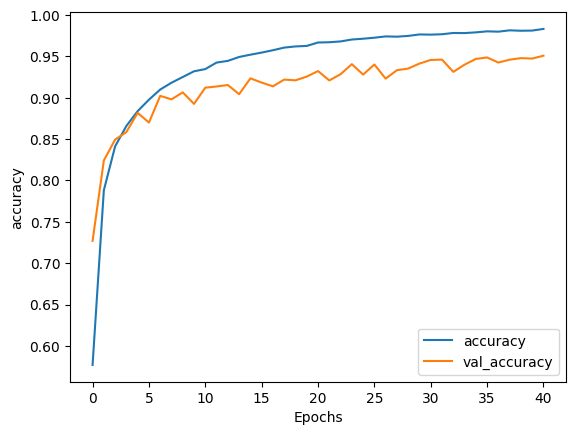

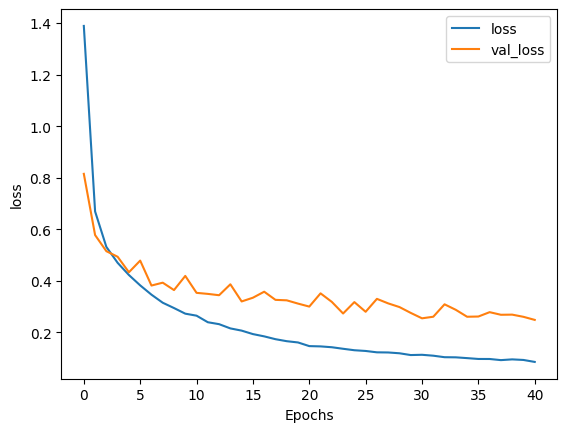

In [47]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [48]:
model.save('model2.h5')
model.save('model2.keras')
model.export('model2')

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


Saved artifact at 'model2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2055269204432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2053535156176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2053535154256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2053535156752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2053332044880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2053535155984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2053332046224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2053332046608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2053332045456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2053332045264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2053332047184: TensorSpec(shape=(), dtype=tf.resourc

In [49]:
pickle.dump({'config': vectorizer.get_config(),
             'weights': vectorizer.get_weights(),
             'vocabulary': vectorizer.get_vocabulary()}
            , open("vectorizer2.pkl", "wb"))

In [50]:
from_disk = pickle.load(open("vectorizer2.pkl", "rb"))
new_v = tf.keras.layers.TextVectorization.from_config(from_disk['config'])
new_v.set_weights(from_disk['weights'])
new_v.set_vocabulary(from_disk['vocabulary'])

print(f"Restored vocabulary size: {len(new_v.get_vocabulary())}")

Restored vocabulary size: 15078


In [69]:
test_set = pd.concat(test_list).reset_index(drop=True)

In [70]:
test_set = custom_resampling(test_set)
test_set.head(15)

,Unnamed: 0,statement,status
11635,11635,Hello.I think I am in bit of dark place in my ...,Depression
52581,52581,First psychiatrists appointment. Meds?! So I m...,Anxiety
39008,39008,tw terrorism death amp x 00b i f australia hav...,Depression
44762,44762,last day at home today catching the train at 0...,Normal
39753,39753,sorry to ask again i m just not doing great at...,Depression
4182,4182,como q jyp ripeo,Normal
49277,49277,just realised my sickness is stress related I ...,Stress
4092,4092,"I'm so bored of the tv in the office, just set...",Normal
28174,28174,"Hi everybody, I'm a 22 year old male who has h...",Stress
32644,32644,i think golfers have a mental problem.,Normal


In [71]:
print(len(train_set), len(val_set), len(test_set))

56304 11256 7512


In [72]:
test_set['statement'] = test_set['statement'].str.lower()
test_set['statement'] = test_set['statement'].apply(expandContractions)
test_set['statement'] = test_set['statement'].apply(tokenize_text)
test_set['statement'] = test_set['statement'].apply(lambda tokens: wordninja.split(" ".join(tokens)))
test_set['statement'] = test_set['statement'].apply(remove_stopwords)
test_set['statement'] = test_set['statement'].apply(remove_non_english)
test_set['statement'] = test_set['statement'].apply(lambda tokens: " ".join(tokens))
test_set.head(15)

,Unnamed: 0,statement,status
11635,11635,hello think bit dark place life think work peo...,Depression
52581,52581,first appointment made appointment anxious cal...,Anxiety
39008,39008,terrorism death x b f crippling anxiety surrou...,Depression
44762,44762,last day home today catching train tomorrow ha...,Normal
39753,39753,sorry ask great moment hypothetically end life...,Depression
4182,4182,q ripe,Normal
49277,49277,sickness stress related barely move nausea who...,Stress
4092,4092,office set meter first,Normal
28174,28174,hi everybody year old male extreme depression ...,Stress
32644,32644,think mental problem,Normal


In [73]:

test_text = test_set['statement'].to_numpy()
test_labels = test_set['status'].to_numpy()

numeric_test_labels = [label_mapping[label] for label in test_labels]

test_labels_one_hot = tf.keras.utils.to_categorical(numeric_test_labels, num_classes=6)

test_dataset = tf.data.Dataset.from_tensor_slices((test_text, test_labels_one_hot))

test_dataset = test_dataset.cache().shuffle(SHUFFLE_BUFFER_SIZE).prefetch(PREFETCH_BUFFER_SIZE).batch(NUM_BATCHES)

test_dataset_vectorized = test_dataset.map(lambda x, y: (new_v(x), y))

In [74]:
print(test_dataset_vectorized.element_spec)
for text_batch, label_batch in test_dataset_vectorized.take(1):
    print(f"Text batch shape: {text_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")

(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, 6), dtype=tf.float64, name=None))
Text batch shape: (64, 200)
Label batch shape: (64, 6)


In [75]:
from tensorflow.keras.models import load_model

# load the saved model
test_model = load_model('model2.h5')

# evaluate the model on the test dataset
loss, accuracy = test_model.evaluate(test_dataset_vectorized)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.7508 - loss: 1.7241
Test Loss: 1.6838750839233398
Test Accuracy: 0.7513312101364136
